In [1]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import statistics
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
import gensim
from gensim.models import KeyedVectors
import numpy as np
from collections import Counter
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases
from nltk import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim.downloader as api
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from preprocessing import *

In [2]:
w2v_pretrained = Word2Vec.load("w2vPreTrained") # carica gli emebdding pre trainati sul dataset test_set.csv

In [3]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t", encoding = "utf-8")
print(dataset.shape)
dataset.dropna(inplace = True)
print(dataset.shape)
dataset.drop(dataset[dataset.rating == 3].index, inplace=True)
print(dataset.shape)
dataset.drop_duplicates(subset = "verified_reviews", inplace = True)
print(dataset.shape)

(3150, 6)
(3150, 6)
(2998, 6)
(2196, 6)


In [4]:
# converte in un formato col quale lalvora imblearn
X = np.array(dataset["verified_reviews"].values).reshape(-1, 1)
y = list(dataset["feedback"].values)

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# classe negativa = 50% della classe positiva
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state = 0)

X, y = undersampler.fit_resample(X, y)


print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({1: 412, 0: 206})


In [6]:
X_temp = []

for rev in X:
  X_temp.append(rev[0])

In [7]:
new_text, new_sent_tok = tokenize_list_of_text(X_temp, custom_stopwords, False, 2)

total number of types extracted is: 1788


In [8]:
# Elimino token con freq minore di 2
cleaned_reviews = frequency_cleaning(new_sent_tok, 2)

In [9]:
bigrams = Phrases(cleaned_reviews, scoring="npmi", threshold=0.60) #estrae le collocazioni tramite PMI
bigrams[cleaned_reviews][2]

['little', 'feature']

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(bigrams[cleaned_reviews], y, test_size=0.20, random_state=10)

In [11]:
print('Train set is %s' % Counter(Y_train))

Train set is Counter({1: 329, 0: 165})


In [12]:
# genera recensioni sintetiche a partire dal train. Queste vengono inserite nel train e usato solo nell'addestramento 
negative_reviews = []
for rev, label in zip(X_train, Y_train):
    if label == 0:
        negative_reviews.append(rev)
    
generated_reviews = generate_samples(negative_reviews, int(len(negative_reviews)/2), w2v_pretrained)

# run this only one time
X_train.extend(generated_reviews)
Y_train.extend([0 for x in generated_reviews])

['joke']
-
['laugh']
--------------------------
['price', 'product', 'nice', 'quality', 'nice', 'feature', 'definitely', 'reason', 'give', 'think', 'may', 'buyer', 'error', 'first', 'ignore', 'product', 'plug', 'time', 'work', 'really', 'unlike', 'not_a', 'stand', 'device', 'also', 'speaker', 'not_very', 'loud', 'buy', 'bluetooth', 'speaker', 'sure', 'lot', 'figure', 'use', 'kind', 'seem', 'like', 'device', 'plus', 'set', 'awful', 'would', 'definitely', 'money', 'buy', 'one', 'actually']
-
['cost', 'product', 'decent', 'quality', 'decent', 'feature', 'definitely', 'reason', 'present', 'imagine', 'may', 'buyer', 'error', 'start', 'ignore', 'product', 'plug', 'sentence', 'run', 'truly', 'different', 'not_a', 'base', 'device', 'also', 'speaker', 'not_very', 'loudly', 'purchase', 'bluetooth', 'speaker', 'sure', 'plenty', 'figure', 'utilize', 'kind', 'seem', 'wish', 'device', 'plus', 'adjust', 'terrible', 'would', 'definitely', 'money', 'purchase', 'one', 'really']
-------------------------

In [13]:
print('Train set is %s' % Counter(Y_train))

Train set is Counter({1: 329, 0: 241})


In [18]:
# tfidf weighting sui token

tfidf = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, min_df = 0)
tfidf_model = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)
review = 1
for score, feature in zip(tfidf_model.toarray()[review], tfidf.get_feature_names_out()):
    if score > 0.0:
        print(feature, score)

bass 0.43857828532933923
get 0.22024499174682433
great 0.2247690722731819
idle 0.29911950316887775
miss 0.36554410475419424
recognize 0.4556341840374841
sound 0.26570121995060786
still 0.2855958668417301
thing 0.24613904269023423
time 0.25529600517955614


In [19]:
tfidf.inverse_transform(tfidf_model)[0]

array(['purchase', 'new', 'like', 'look', 'box', 'original',
       'even_though', 'perfectly', 'work', 'far', 'week', 'two',
       'refurbish', 'happy'], dtype='<U15')

In [20]:
print(tfidf_model[0,:].data)
tfidf.inverse_transform(tfidf_model)[0]

[0.2030027  0.2146646  0.16414036 0.22487128 0.28412446 0.26694879
 0.27777188 0.29964046 0.14736372 0.21283613 0.27208931 0.2374712
 0.2295642  0.51587761]


array(['purchase', 'new', 'like', 'look', 'box', 'original',
       'even_though', 'perfectly', 'work', 'far', 'week', 'two',
       'refurbish', 'happy'], dtype='<U15')

In [21]:
# guardati word2vec
w2v_model = Word2Vec(X_train, vector_size=100, window = 10, min_count = 0, sg=1, hs = 1, epochs= 100, seed = 5)

In [22]:
w2v_model.wv.most_similar("love", topn = 10)

[('great', 0.4427104592323303),
 ('use', 0.41806232929229736),
 ('cook', 0.41679319739341736),
 ('trailer', 0.3842005133628845),
 ('list', 0.3723629117012024),
 ('movie', 0.3719281852245331),
 ('find', 0.36989104747772217),
 ('want', 0.3640190362930298),
 ('favorite', 0.3593107759952545),
 ('live', 0.3583296835422516)]

In [23]:
w2v_model.wv.most_similar("love", topn = 2000)[-10:]

[('unplug', -0.060755953192710876),
 ('money', -0.0664283037185669),
 ('listen', -0.06782251596450806),
 ('phone', -0.07216014713048935),
 ('zigbee', -0.0758974477648735),
 ('useful', -0.0774853527545929),
 ('half', -0.07899769395589828),
 ('return', -0.08647407591342926),
 ('ignore', -0.11667533963918686),
 ('also', -0.1351698786020279)]

In [25]:
g_model = []
# google_model = api.load('word2vec-google-news-300', True)
# g_model = KeyedVectors.load_word2vec_format(google_model, binary=True)

In [26]:
def review_vectors(tokens, size = 300, weights = [], pretrained = False):

    """Genera un vettore per ogni recensione: questo vettore
    è calcolato come la media ponderata (t * w: token vettore * peso tfidf) dei vettori dei token nella recensione.
    Il vettore risultante è normalizzato alla fine."""

    vec = np.zeros(size).reshape((1, size))
    count = 0

    import statistics

    # if len(tokens) != len(weights):
    #     print("nope")

    for word, weight in zip(tokens, weights):
        try:
            if pretrained:
                vec += g_model[word]
            else:
                vec += w2v_model.wv[word] * weight
            count +=1
        except KeyError:
            print("non trovo", word)
            continue

    if count!= 0:
        vec = vec / norm(vec)
        
    return vec

In [27]:
# qui viene creato per ogni recensione nel train il vettore

w2v_X_train = np.zeros((len(X_train), w2v_model.vector_size))
for i in range(len(X_train)):
    w2v_X_train[i,:] = review_vectors(tfidf.inverse_transform(tfidf_model[i, :])[0], w2v_model.vector_size, tfidf_model[i,:].data, False)
w2v_df = pd.DataFrame(w2v_X_train)
w2v_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.082661,-0.151349,-0.074861,0.037644,-0.066720,0.020614,-0.011829,-0.013392,0.176482,-0.062259,...,0.260962,-0.014683,-0.199772,0.059695,-0.167980,0.148148,0.021638,-0.011035,0.135206,-0.107616
1,-0.010352,0.124167,-0.066428,-0.006570,0.084815,0.066799,-0.015148,-0.080436,0.349077,0.013362,...,-0.020216,-0.003028,0.030448,0.011085,-0.092804,-0.092104,-0.167296,0.066248,0.080724,-0.131726
2,-0.081078,0.065077,0.020466,0.089001,0.026016,0.060755,-0.083836,-0.036419,0.224987,-0.214554,...,0.027708,-0.022021,-0.130736,0.073863,-0.040524,0.041428,-0.262506,-0.102492,-0.001444,-0.006964
3,-0.020931,-0.121961,0.086868,0.145419,-0.006566,0.070374,0.088383,-0.196185,0.179465,-0.215866,...,0.096553,-0.030167,-0.172984,-0.064320,0.070422,0.087514,0.010783,-0.023238,-0.024379,-0.023307
4,-0.007993,-0.134710,-0.004358,0.008124,0.054364,-0.095766,-0.063901,-0.149381,0.069085,-0.160243,...,-0.074324,-0.044782,-0.103724,0.085569,-0.113287,0.023187,-0.009778,-0.042310,0.032383,-0.023744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0.092891,-0.049497,0.126576,0.222127,0.004577,0.009966,0.064977,-0.123570,0.256325,-0.092065,...,-0.023982,-0.111851,0.000682,0.030012,0.011261,0.137632,0.026720,0.129006,0.083195,0.049920
566,-0.033429,-0.122769,0.129234,0.215405,-0.024994,0.105432,0.078928,-0.060020,0.177562,-0.024568,...,-0.019832,-0.163454,-0.095019,-0.091874,-0.104988,-0.028811,-0.044012,0.096476,0.089489,0.086941
567,-0.062392,0.007327,-0.040919,0.074444,0.186170,-0.036118,0.062157,0.035439,0.211875,-0.113488,...,0.062863,-0.012930,0.028464,-0.000373,-0.112696,0.147093,-0.004722,-0.102671,0.070785,-0.056772
568,-0.167299,0.016471,-0.089182,0.076275,-0.068885,0.175730,-0.087284,-0.135165,0.215760,0.032030,...,0.051133,-0.065443,0.104939,0.203143,-0.040604,0.077434,0.030943,-0.037719,0.022663,-0.017760


In [28]:
# qui nel test
X_test_vec = np.zeros((len(X_test), w2v_model.vector_size))
for i in range(len(X_test)):
    X_test_vec[i,:] = review_vectors(tfidf.inverse_transform(X_test_tf[i, :])[0], w2v_model.vector_size, X_test_tf[i,:].data, False)

X_test_vec[0]

array([-0.09796571, -0.05063917,  0.05146904,  0.11736339,  0.2076852 ,
       -0.0471553 ,  0.09654809, -0.00155005,  0.30690635, -0.02967472,
       -0.02388178,  0.11938095, -0.02534537,  0.12799129,  0.10167499,
       -0.10421469,  0.10883549,  0.08599854, -0.03560749, -0.00178783,
        0.02545134, -0.16636523, -0.07562098,  0.07502693,  0.11941628,
       -0.05619449, -0.02622915,  0.05945934, -0.11072277,  0.08513432,
       -0.01176532,  0.01930633, -0.14103425, -0.00137947,  0.02484548,
        0.01266838, -0.0228536 ,  0.02886759, -0.05492892,  0.02782465,
        0.11813099, -0.24066323,  0.04595065, -0.09356211, -0.11506018,
        0.08431791,  0.06044759,  0.27586866,  0.04219858,  0.05169447,
        0.01478931,  0.19195981, -0.16157895, -0.04896496,  0.10925801,
       -0.00565317,  0.05256285,  0.12761391, -0.01392935,  0.01015895,
       -0.00823835, -0.19846998,  0.02798776, -0.04722525,  0.19635504,
       -0.00656834, -0.03750321,  0.00574192, -0.12432743, -0.11

In [29]:
from imblearn.under_sampling import TomekLinks

undersampler_nn = TomekLinks(sampling_strategy="all") # use tomeLinks to remove ambiguous data through nearest neighbours


# Fit and transform the X and y data
X_train_resampled, y_train_resampled = undersampler_nn.fit_resample(w2v_X_train, Y_train)

print('Resampled dataset shape %s' % Counter(y_train_resampled))

Resampled dataset shape Counter({1: 319, 0: 231})


In [30]:
svm = SVC(max_iter=3000, class_weight = "balanced", C = 1, gamma = 1, kernel = "poly", probability=True)
svm_model = svm.fit(X_train_resampled, y_train_resampled)
predictions = svm_model.predict(X_test_vec)
print(metrics.classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.80      0.77        41
           1       0.90      0.86      0.88        83

    accuracy                           0.84       124
   macro avg       0.82      0.83      0.82       124
weighted avg       0.84      0.84      0.84       124



In [31]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

In [32]:
# estrae le probabilità di ogni prediction, serve a plottare la roc-auc curve
y_test_pred_proba = svm_model.predict_proba(X_test_vec)

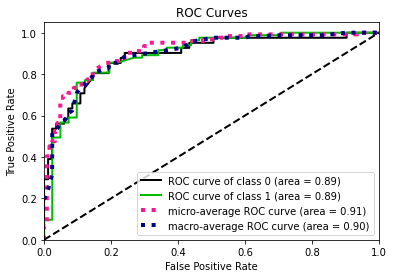

0.893329415221863


In [33]:
plot_roc(Y_test, svm_model.predict_proba(X_test_vec))
plt.show()
print(roc_auc_score(Y_test, y_test_pred_proba[:,1], average="macro"))

In [34]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [35]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear', 'poly'],
              'class_weight':['balanced', None],
}

In [36]:
grid = GridSearchCV(SVC(), param_grid, refit = True, scoring = "f1", cv=kfold, verbose=3)
grid.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.864 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.938 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.828 total time=   0.1s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.883 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.882 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.937 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.806 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.902 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=lin

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='f1', verbose=3)

In [37]:
print(grid.best_params_)

{'C': 1, 'class_weight': None, 'gamma': 1, 'kernel': 'poly'}


In [38]:
grid_predictions = grid.predict(X_test_vec)
print(classification_report(Y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.77      0.73      0.75        41
           1       0.87      0.89      0.88        83

    accuracy                           0.84       124
   macro avg       0.82      0.81      0.82       124
weighted avg       0.84      0.84      0.84       124



In [39]:
review = """To be fair i don't like this version, it's very loud and the sound quality is poor"""

review_tok = tokenize_list_of_text([review], custom_stopwords, False, 2)[1]
print(review_tok)
review_vec = review_vectors(review_tok[0], w2v_model.vector_size, [1 for x in range(len(review_tok[0]))])
pred = grid.predict(review_vec)
pred

total number of types extracted is: 7
[['fair', 'unlike', 'version', 'loud', 'sound', 'quality', 'poor']]
non trovo fair
non trovo version


array([0])